In [1]:
#packages needed to run this notebook 
import numpy as np 
import pandas as pd 
import transformers 
import pycaret 
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
#if using GPU
device = torch.device("cuda")

##### The following cells comprise of the data preparation

In [2]:
#loading in the data set 
true_df = pd.read_csv("/home/fjp8ez/deep_learning/DS6050-Final-Project/data/a1_True.csv")
fake_df = pd.read_csv("/home/fjp8ez/deep_learning/DS6050-Final-Project/data/a2_Fake.csv")

#generating true and fake labels under a new target column 
true_df['Target'] = ['True']*len(true_df)
fake_df['Target'] = ['Fake']*len(fake_df)

#merging true and fake data (random mixing into single df)
full_df = true_df.append(fake_df).sample(frac=1).reset_index().drop(columns=['index'])

print(full_df.shape)
full_df.head(20)
full_df['text']


(44898, 5)


0        Footage has been released of a leader of the R...
1        Robert Fantina CounterpunchAlthough the United...
2                                                         
3        WASHINGTON (Reuters) - The United States has a...
4        BRASILIA (Reuters) - A leniency deal struck be...
                               ...                        
44893    DNC staffer Seth Rich was shot in the back sev...
44894    Melania Trump has been taking a relatively low...
44895    WASHINGTON (Reuters) - Constant cyber attacks ...
44896    Donald Trump s visit to Israel had a stop at Y...
44897    (Reuters) - The U.S. Senate on Monday confirme...
Name: text, Length: 44898, dtype: object

In [3]:
#target column is current T or F, changing to 1 if fake and 0 of true
full_df['label'] = pd.get_dummies(full_df.Target)['Fake']
full_df.head()

,title,text,subject,date,Target,label
0,RNC Leader’s Backstage Rant Shows What The GO...,Footage has been released of a leader of the R...,News,"January 15, 2016",Fake,1
1,Hillary Clinton: ‘Israel First’ (and no peace ...,Robert Fantina CounterpunchAlthough the United...,US_News,"January 18, 2016",Fake,1
2,WOW! FORMER AMBASSADOR TO RUSSIA Lists Failure...,,Government News,"Dec 13, 2016",Fake,1
3,U.S. has 'ironclad' commitment to NATO mutual ...,WASHINGTON (Reuters) - The United States has a...,politicsNews,"July 21, 2016",True,0
4,Brazil prosecutor says new audio threatens Bat...,BRASILIA (Reuters) - A leniency deal struck be...,worldnews,"September 4, 2017",True,0


#### Exploratory Data Analysis

##### Train/Val/Test Split

In [4]:
train_text, temp_text, train_labels, temp_labels = train_test_split(full_df['title'], full_df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=full_df['Target'])
                    
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

##### Fine Tuning BERT

In [5]:
# Loading in bert model and tokenizer from hugging face
bert_model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Text(0, 0.5, 'Number of texts')

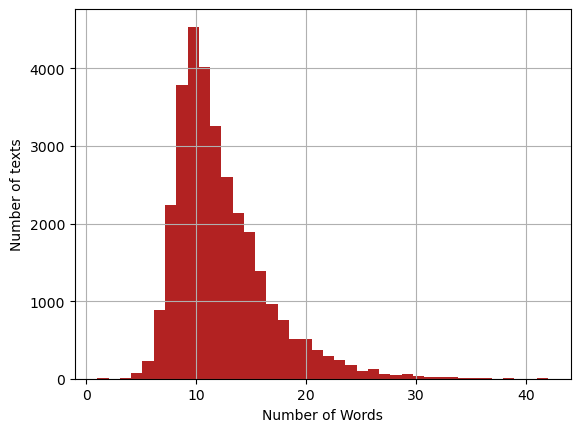

In [6]:
seq_len = [len(text.split()) for text in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In the histogram above, we can see that the majority of the titles have a word length of under 15. Given that, we will set the max title length to 15 and tokenize each title. 

In [7]:
max_title_length = 15

#useing tokenizer to encode sequences in the training dataset
train_tokens = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_title_length,
    pad_to_max_length = True,
    truncation = True
)

#same process for test and val set
test_tokens = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_title_length,
    pad_to_max_length = True,
    truncation = True
)

val_tokens = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_title_length,
    pad_to_max_length=True,
    truncation=True
)

In [8]:
#converting all model data to tensors 
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(val_tokens['input_ids'])
val_mask = torch.tensor(val_tokens['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

##### Data loader structure definition 
below we will..
- define batch size
- wrap tensors 
- use sampler for sampling the data during training 
- define dataloaders for all three sets of data


In [9]:
from torch.utils.data import TensorDataset, DataLoader,RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq,train_mask,train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)           
val_sampler = SequentialSampler(val_data)                     
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [10]:
#Freezing Bert MOdel 
for param in bert_model.parameters():
    param.requires_grad = False    #use false here tell the training process
    #not the update gradients

#### Below is the code to define the Bert architecture

In [17]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertModel

class BERTClassifier(nn.Module):
    def __init__(self, bert_model: BertModel):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.pooler_output
        return self.classifier(cls_output)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = BERTClassifier(bert_model).to(device)

# Optimizer & Loss
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.NLLLoss().to(device)

# Training params
epochs = 10

##### Below we are identifying our training and evaluation functions

In [18]:
def train_epoch(dataloader):
    model.train()
    total_loss, correct_preds = 0, 0

    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct_preds += (preds == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = correct_preds / len(dataloader.dataset)
    return avg_loss, avg_acc


def eval_epoch(dataloader):
    model.eval()
    total_loss, correct_preds = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = correct_preds / len(dataloader.dataset)
    return avg_loss, avg_acc


##### Model Training and prediction

In [19]:
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    train_loss, train_acc = train_epoch(train_dataloader)
    val_loss, val_acc = eval_epoch(val_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_bert_model.pt")



Epoch 1/10
Train Loss: 0.5715 | Train Acc: 0.7009
Val   Loss: 0.5030 | Val   Acc: 0.7538

Epoch 2/10
Train Loss: 0.4828 | Train Acc: 0.7790
Val   Loss: 0.4146 | Val   Acc: 0.8293

Epoch 3/10
Train Loss: 0.4224 | Train Acc: 0.8149
Val   Loss: 0.3642 | Val   Acc: 0.8589

Epoch 4/10
Train Loss: 0.3857 | Train Acc: 0.8358
Val   Loss: 0.3355 | Val   Acc: 0.8655

Epoch 5/10
Train Loss: 0.3622 | Train Acc: 0.8454
Val   Loss: 0.3179 | Val   Acc: 0.8696

Epoch 6/10
Train Loss: 0.3453 | Train Acc: 0.8518
Val   Loss: 0.3118 | Val   Acc: 0.8692

Epoch 7/10
Train Loss: 0.3349 | Train Acc: 0.8582
Val   Loss: 0.2874 | Val   Acc: 0.8846

Epoch 8/10
Train Loss: 0.3273 | Train Acc: 0.8613
Val   Loss: 0.2827 | Val   Acc: 0.8863

Epoch 9/10
Train Loss: 0.3194 | Train Acc: 0.8646
Val   Loss: 0.2789 | Val   Acc: 0.8860

Epoch 10/10
Train Loss: 0.3151 | Train Acc: 0.8655
Val   Loss: 0.2709 | Val   Acc: 0.8873
